# EDA: Исследование исходных текстов (до очистки)

Цель: провести предварительный анализ сырых данных до этапа очистки.  
Это поможет:
- выявить мусор, дубликаты и пустые строки,
- понять распределение длин текстов,
- принять решения о порогах фильтрации (например, длина ≥ 20).

Источник данных: `data/RuBQ_2.0_paragraphs.json`

In [55]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

plt.style.use("ggplot")

# Загрузка данных
with open("C:/Users/User/Desktop/Партфолио/rag_qa_project/data/RuBQ_2.0_paragraphs.json", encoding="utf-8") as f:
    raw_data = json.load(f)

df_raw = pd.DataFrame(raw_data)
df_raw.head()


,uid,ru_wiki_pageid,text
0,0,58311,ЦСКА — советский и российский профессиональный...
1,1,58311,В первом сезоне в составе Континентальной хокк...
2,2,58311,В межсезонье 1992 года «армейскую» команду пок...
3,3,58311,"Однако ни Тихонов, ни Гущин, не согласились с ..."
4,4,58311,ЦСКА Александра Волчкова сезон 1996/97 провел ...


### Анализ длины и структуры текстов

На этом этапе:
- Рассчитываем длину каждого текстового блока (в символах).
- Получаем базовую статистику по длине: среднее, медиана, минимум, максимум.
- Строим гистограмму, чтобы визуально оценить распределение.

Это позволит обоснованно установить порог минимальной длины текста для фильтрации.


,uid,ru_wiki_pageid,text,text_length
0,0,58311,ЦСКА — советский и российский профессиональный...,431
1,1,58311,В первом сезоне в составе Континентальной хокк...,471


uid                int64
ru_wiki_pageid     int64
text              object
text_length        int64
dtype: object

,text_length
count,56952.000000
mean,448.516575
std,415.260130
min,1.000000
25%,172.000000
50%,343.000000
75%,600.000000
max,11010.000000


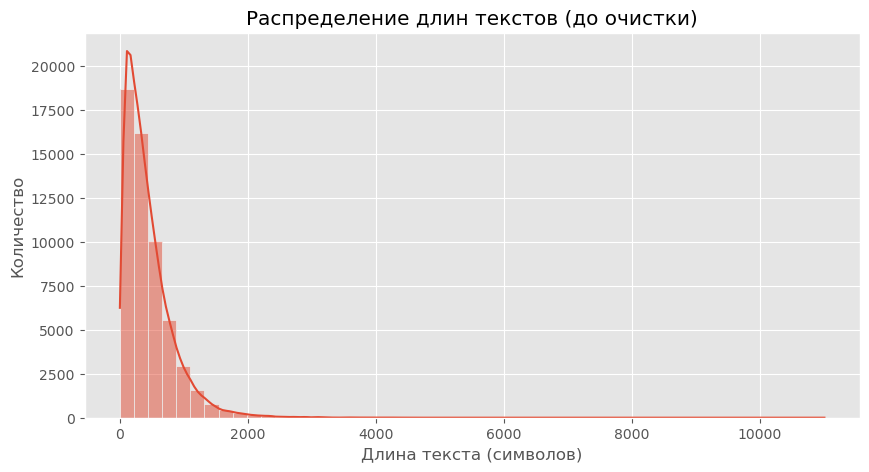

In [21]:
# ➤ Общая информация о DataFrame
import IPython.display as dsp

dsp.display(df_raw.head(2))  # Пример структуры
dsp.display(df_raw.dtypes)   # Типы данных

# ➤ Расчёт длины текста
df_raw["text_length"] = df_raw["text"].apply(lambda x: len(str(x)) if pd.notnull(x) else 0)

# ➤ Вывод describe в табличном виде
dsp.display(df_raw["text_length"].describe().to_frame(name="text_length"))

# ➤ Гистограмма длин текстов
plt.figure(figsize=(10, 5))
sns.histplot(df_raw["text_length"], bins=50, kde=True)
plt.title("Распределение длин текстов (до очистки)")
plt.xlabel("Длина текста (символов)")
plt.ylabel("Количество")
plt.show()


### Предварительные наблюдения по длине текстов

- Распределение длин текстов показывает правосторонний хвост: большинство чанков находятся в диапазоне **100–600 символов**, но встречаются и **очень длинные фрагменты** (до 11 000+ символов).
- Есть **единичные тексты длиной < 20 символов**, они будут дополнительно рассмотрены в следующем анализе.
- Минимальные, максимальные и медианные значения уже дают общее представление о разбросе.

 Гистограмма хорошо иллюстрирует плотность и выбросы — это поможет сформулировать критерии фильтрации на этапе предобработки.

 Продолжим анализ с фокусом на:
- Пустые строки и дубликаты;
- Короткие тексты;
- Возможные аномалии в данных.


### Проверка на пустые тексты и дубликаты

In [25]:
# ➤ Проверка на пустые тексты и дубликаты
empty_count = df_raw["text"].isnull().sum() + (df_raw["text"].apply(lambda x: str(x).strip()) == "").sum()
duplicate_ids = df_raw["uid"].duplicated().sum()
duplicate_texts = df_raw["text"].duplicated().sum()

print(f"Пустые тексты: {empty_count}")
print(f"Дубликаты по uid: {duplicate_ids}")
print(f"Дубликаты по text: {duplicate_texts}")


Пустые тексты: 0
Дубликаты по uid: 0
Дубликаты по text: 126


Как мы видим **пустые тексты отсутствуют**, что хорошо.

**UID уникальны** — можно использовать как идентификатор чанка.

**Обнаружено 126 дубликатов по полю `text`** — они будут рассмотрены для возможного удаления на этапе очистки.


### Анализ коротких текстов и дубликатов

In [44]:
# ➤ Посмотрим примеры коротких текстов (< 20 символов)
short_texts = df_raw[df_raw["text_length"] < 20].sort_values("text_length")
short_texts[["uid", "text_length", "text"]].head(20)


,uid,text_length,text
19717,19717,1,.
28798,28798,1,.
52799,52799,1,.
25705,25705,1,.
21129,21129,1,.
52793,52793,1,.
51984,51984,1,.
51980,51980,1,.
20390,20390,1,.
51970,51970,1,.


In [42]:
# ➤ Посмотрим дубликаты по text
duplicated_texts = df_raw[df_raw.duplicated("text", keep=False)]
duplicated_texts.sort_values("text")[["uid", "text_length", "text"]].head(10)


,uid,text_length,text
30016,30016,15,6
30013,30013,15,6
46769,46769,13,3
3760,3760,13,3
50381,50381,13,3
25705,25705,1,.
28798,28798,1,.
28817,28817,1,.
32798,32798,1,.
28950,28950,1,.


- Примеры текстов длиной < 20 символов включают `"."`, `"3"`, `"6"` — они не содержат никакой полезной информации.
- Большинство дубликатов — это именно такие короткие, технические или случайные строки.

Решение:
  - Удалять все тексты длиной < 20 символов,
  - Удалять точные дубликаты по `text`.

Эти правила будут реализованы в пайплайне предобработки.


### Посмотрим уникальные статьи:

In [50]:
# Сколько уникальных статей представлено в датасете
num_unique_pages = df_raw["ru_wiki_pageid"].nunique()
total_chunks = len(df_raw)

print(f"Уникальных wiki-страниц: {num_unique_pages}")
print(f"Среднее количество чанков на статью: {total_chunks // num_unique_pages}")


Уникальных wiki-страниц: 9105
Среднее количество чанков на статью: 6


### Частотный анализ токенов (по верхам):

In [57]:
# Объединяем все тексты и "наивно" разбиваем на слова
all_text = " ".join(df_raw["text"])
tokens = re.findall(r"\b\w{3,}\b", all_text.lower())  # токены длиной ≥ 3
token_counts = Counter(tokens)

# Топ-20 самых частых слов
token_counts.most_common(20)


[('года', 24554),
 ('что', 18408),
 ('году', 17726),
 ('его', 13619),
 ('как', 13424),
 ('был', 13297),
 ('для', 12769),
 ('также', 9167),
 ('после', 8552),
 ('было', 7715),
 ('была', 7661),
 ('были', 7638),
 ('при', 6803),
 ('время', 6775),
 ('это', 6391),
 ('или', 5901),
 ('так', 4867),
 ('под', 4823),
 ('более', 4266),
 ('который', 4229)]

### Проверим, что у нас по битым символам:

In [74]:
# Регулярка для реально "битых" или невидимых символов
BAD_UNICODE_RE = re.compile(r"[\u200b\u200c\u200d\u200e\u200f\u202a-\u202e\ufeff\ufffd]")

# Фильтрация подозрительных текстов
suspicious = df_raw[df_raw["text"].str.contains(BAD_UNICODE_RE, na=False)]

print(f"Подозрительных текстов с битым юникодом: {len(suspicious)}")
suspicious.sample(5, random_state=42)  # посмотри глазами примеры


Подозрительных текстов с битым юникодом: 189


,uid,ru_wiki_pageid,text
56144,56144,72717,Кандага́р (пушту کندهار‎ /kand̪ahɑr/ — Кандаха...
49758,49758,3676638,Зайна́б бинт Хуза́йма (араб. زينب بنت خزيمة‎; ...
8244,8244,6102660,20 июля 2013 года издание The Hollywood Report...
6519,6519,19050,Совет Безопасности ООН (англ. United Nations S...
24922,24922,1267112,"Аль-А́ндалус (араб. الأندلس‎) — название, под ..."


In [76]:
for i, text in enumerate(suspicious["text"].head(20), 1):
    print(f"{i}. {repr(text[:300])}")  # выводим первые 300 символов и экранируем для анализа


1. '7 апреля 2017 года США нанесли ракетный удар по \u200bавиабазе сирийских правительственных сил в провинции Хомс. Как сообщили в Пентагоне, \u200bкорабли ВМС США, дислоцированные в Средиземном море, выпустили 59 ракет «Томагавк» по взлётным полосам, стоянкам самолётов и заправочным комплексам авиабазы. Операци'
2. '11 апреля Трамп подписал протокол о вступлении Черногории в НАТО. 18 апреля Дональд Трамп подписал указ «Покупай американское, нанимай американцев» о поддержке американских рабочих и товаров. Суть документа — стимулирование производства внутри страны. 21 апреля Дональд Трамп подписал указы о реформи'
3. 'Еги́пет (араб. مصر\u200e Миср/Miṣr [misˤɾ], масри مصر Маср/Maṣr [ˈmɑsˤɾ], копт. Ⲭⲏⲙⲓ [kʰēmi]), официальное название: Ара́бская Респу́блика Еги́пет (араб. جمهورية مصر العربية\u200e Джумхурийят Миср аль-Арабийя, масри جمهورية مصر العربية Гумхурия Маср иль-Арабийя) — государство, расположенное в Северной Африке '
4. 'Народами Аравийского полуострова, Передней Азии и Двуречья

## Общий вывод по анализу сырых данных

В результате базового и расширенного анализа датасета `RuBQ_2.0_paragraphs.json` получены следующие ключевые наблюдения:

### Структура и длина текстов
- Всего текстовых чанков: **56 952**
- Минимальная длина текста: **1 символ**
- Средняя длина: **~448 символов**, медианная: **343**
- Распределение имеет правосторонний хвост — большинство текстов в пределах **100–600 символов**
- Выявлено **293 текста < 20 символов**, среди них — бессмысленные фрагменты: `"."`, `"3"`, `"6"`

### Качество и дубликаты
- **Пустых и null-значений** в `text` — нет
- **UID уникальны**, могут использоваться как идентификаторы
- Обнаружено **126 дубликатов по `text`**, большинство из которых — короткие или технические фрагменты

### Расширенные проверки
- Уникальных wiki-страниц (`ru_wiki_pageid`): **9105**, что даёт в среднем **6 чанков на статью**
- Частотный анализ подтверждает, что тексты осмысленные (топ-слова: "года", "году", "после", "также", "время")
- Найдено **189 текстов с битым или нестандартным юникодом** — этот тип шума будет удалён регуляркой в `clean_text()`, обращаю внимание что именно с битым или нестандартным юникодом, на другие языки, фонетику и спецсимволы (например символ евро или доллара) и т.д., он не распространяется, что бы мы не потеряли нужные данные.

---

### Решения для этапа предобработки:
- Удалять тексты короче **20 символов**
- Удалять точные дубликаты по `text`
- Удалять битые/нестандартные символы с помощью регулярного выражения


# Проверка данных после очистки

Теперь проверим, как изменилась структура данных после применения пайплайна очистки (`preprocess_text_chunks()`):
- Сколько текстов осталось;
- Удалились ли тексты < 20 символов;
- Удалились ли дубликаты по `text`;
- Были ли удалены битые символы.

In [86]:
SUSPICIOUS_UNICODE_RE = re.compile(r"[\u200b\u200e\u200f\u202a-\u202e\ufeff\ufffd]", flags=re.UNICODE)

# Загрузка очищенных текстов
with open("C:/Users/User/Desktop/Партфолио/rag_qa_project/data/cleaned_text_chunks.json", encoding="utf-8") as f:
    cleaned_data = json.load(f)

df_clean = pd.DataFrame(cleaned_data)

# Проверка: минимальная длина текста
min_len = df_clean["text"].apply(len).min()

# Проверка: дубликаты по text
num_duplicates = df_clean["text"].duplicated().sum()

# Проверка: остались ли битые юникод-символы?
num_bad_unicode = df_clean["text"].apply(lambda x: bool(SUSPICIOUS_UNICODE_RE.search(x))).sum()

# Вывод
print(f"Всего после очистки: {len(df_clean)} текстов")
print(f"Минимальная длина текста: {min_len}")
print(f"Дубликатов по text: {num_duplicates}")
print(f"Текстов с битым юникодом: {num_bad_unicode}")


Всего после очистки: 56333 текстов
Минимальная длина текста: 20
Дубликатов по text: 0
Текстов с битым юникодом: 0


## Валидация перед векторизацией

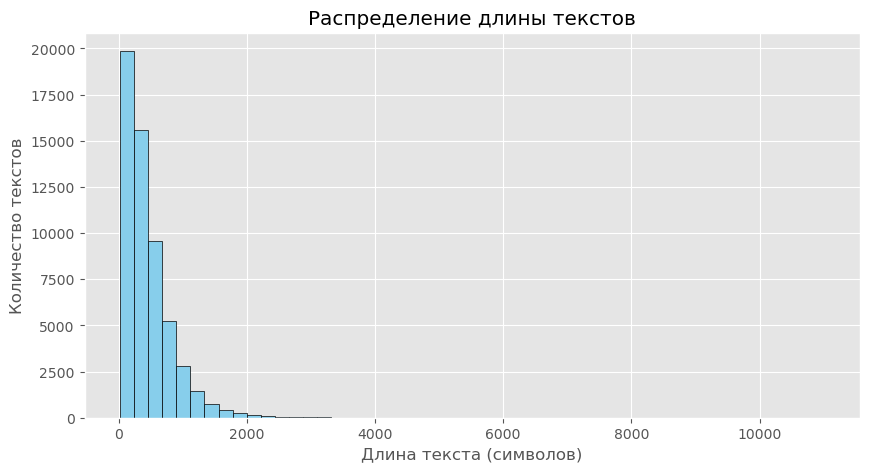

,id,length,text
39843,40233,20,социальной политики.
11980,12093,20,1965—1967 — «Иртыш».
47178,47674,20,Гималаи — от 5000 м.
41587,41995,20,Шкала депрессии Бека
12228,12345,20,Чемпионат Португалии
28314,28559,20,Премия Японии (2011)
36400,36752,20,"Арист, брат Кризаля."
50383,50932,20,Ашанти — поп-певица.
52910,53484,20,Сказки братьев Гримм
46184,46668,20,Швейцария — 9 место.


In [92]:
# Добавляем длину текста как отдельную колонку
df_clean["length"] = df_clean["text"].apply(len)

# Гистограмма длины
plt.figure(figsize=(10, 5))
plt.hist(df_clean["length"], bins=50, color="skyblue", edgecolor="black")
plt.title("Распределение длины текстов")
plt.xlabel("Длина текста (символов)")
plt.ylabel("Количество текстов")
plt.grid(True)
plt.show()

# 10 самых коротких текстов
shortest = df_clean.sort_values("length").head(10)[["id", "length", "text"]]
shortest



Как мы видим очистка выполнена корректно:

- Минимальная длина текста ≥ 20 — фильтрация коротких строк работает.
- Дубликаты по text успешно удалены.
-  Битый или нестандартный юникод отсутствует — регулярное выражение эффективно удаляет мусорные символы, не затрагивая полезные элементы (например, транскрипции, символы валют, арабский и иврит).
- Минимальная длина текста соблюдена.
- Короткие тексты не мусорные, имеют смысл и сохраняют ценность.
- Распределение адекватное.
  
Данные готовы для этапа векторизации.